#Importing all the libraries and modules we will be using


In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf

## **Importing the data as a raw archive**

PetImages is the name of the folder we will be accessing

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls
!ls PetImages


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  86.7M      0  0:00:09  0:00:09 --:--:--  105M
 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data
Cat  Dog


##Filtering out the data

 If the file is not a valid JPEG image, the code deletes the file using os.remove(fpath) and increments the num_skipped counter.

In [ ]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                if b"JFIF" not in fobj.peek(10):
                    os.remove(fpath)
                    num_skipped += 1
        except:
            os.remove(fpath)
            num_skipped += 1

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## Creating two datasets, train_ds and val_ds, from a directory of images using the image_dataset_from_directory function from Keras' utils module.

In [ ]:
image_size = (128, 128)
batch_size = 64

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


#The resulting plot will display 9 images from the batch, arranged in a 3x3 grid, with each image's label displayed as the title of the subplot.

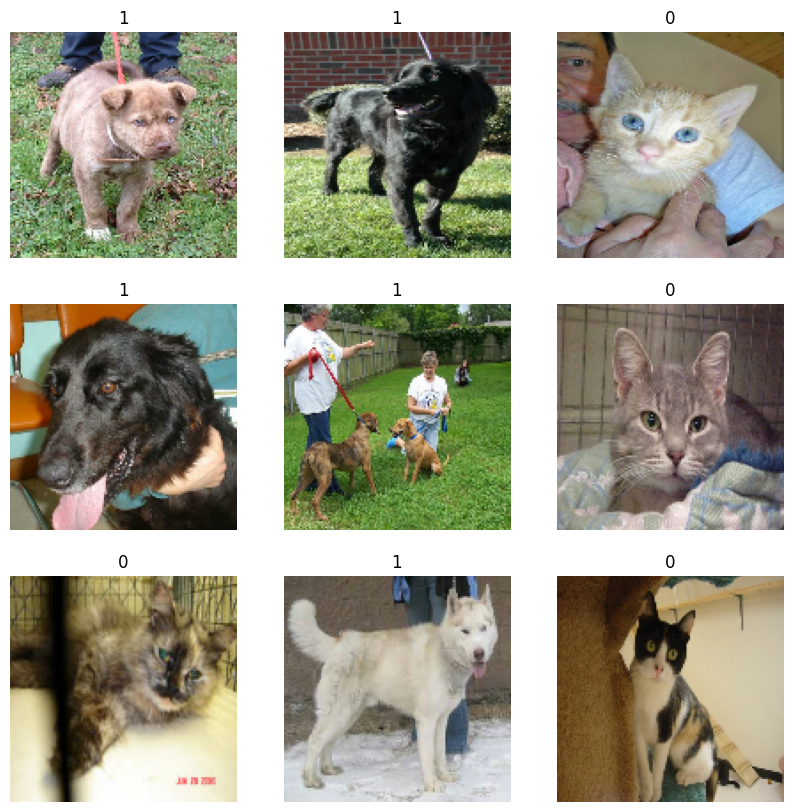

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#Using image data augmentation

#When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images



#The resulting plot will display 9 images from the batch, arranged in a 3x3 grid,
#applying data augmentation repeatedly to the first few images in the dataset

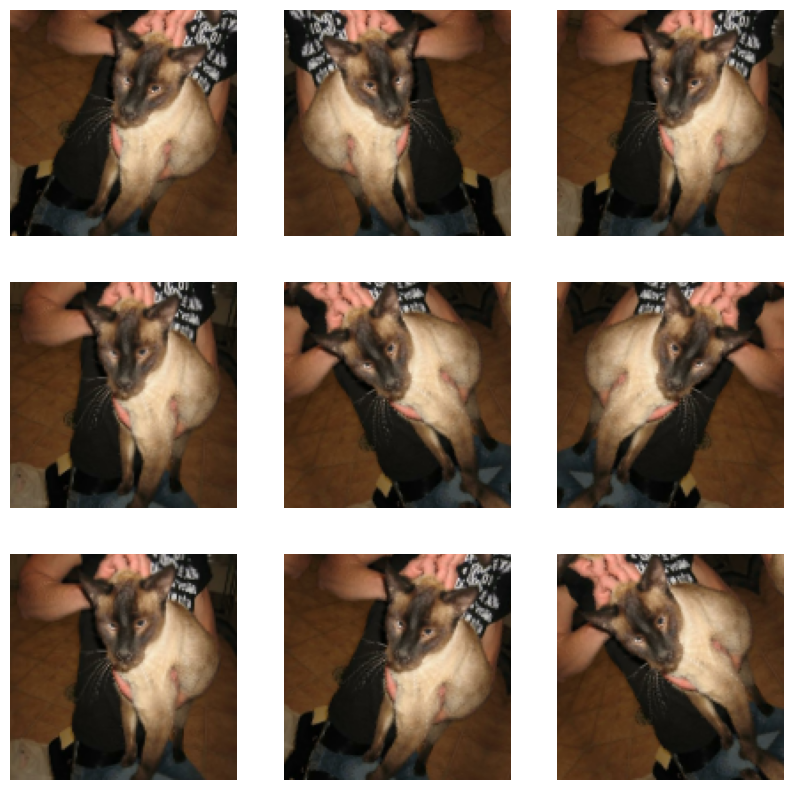

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

#Building a model for the dataset

# Defining the model architecture and optimising using batch normalisation and dropout

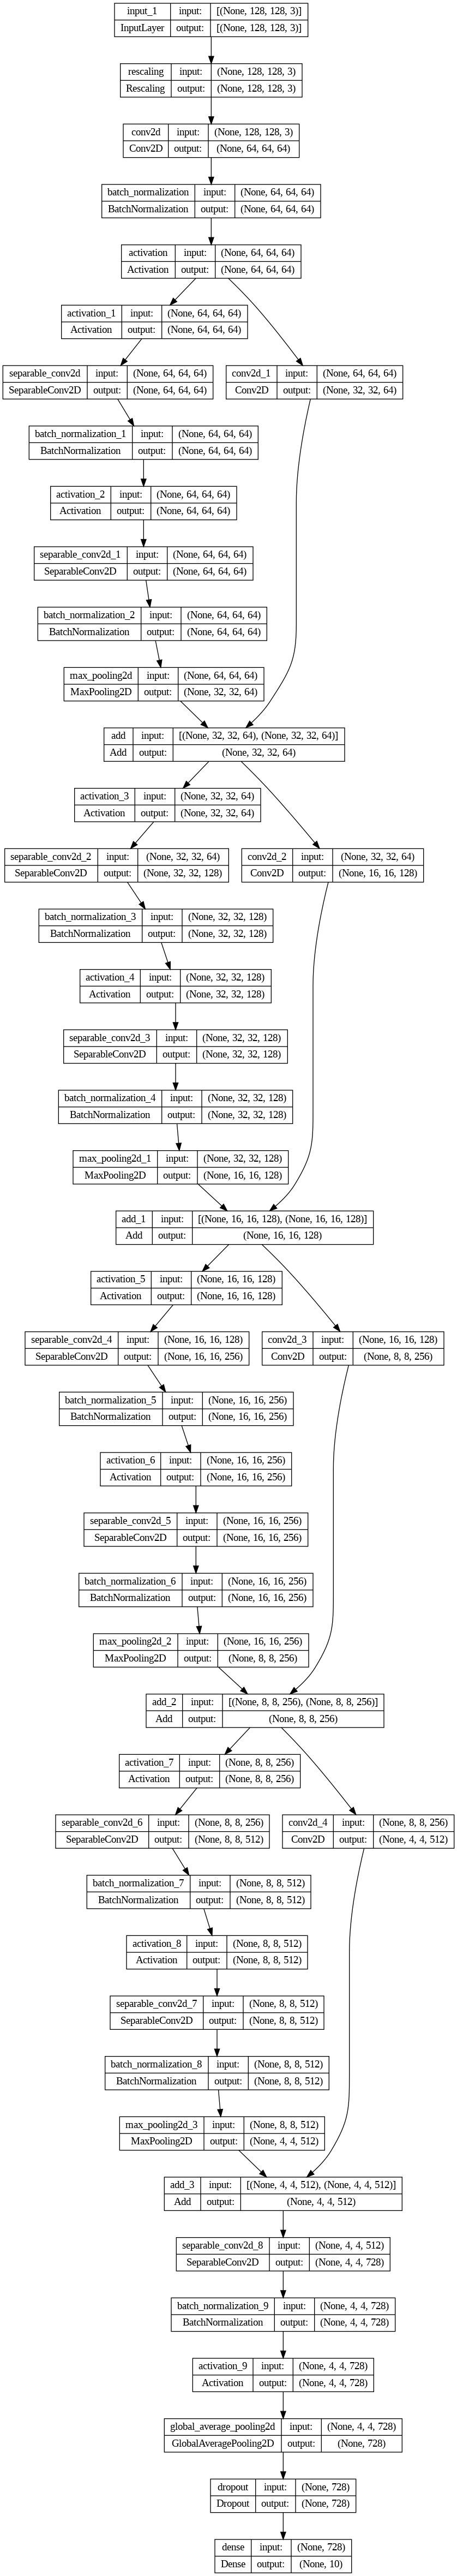

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [64, 128, 256, 512]:  # Reduced filters
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(728, 3, padding="same")(x)  # Reduced filters
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

# Create the model
input_shape = (128, 128, 3)  # Example input shape
num_classes = 10  # Example number of classes
model = make_model(input_shape, num_classes)

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='model_plot.png')


#Compiling the model

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Create data generators for training and validation

In [ ]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Define callbacks
Callbacks in TensorFlow and Keras are objects that can perform actions at various stages during training to optimise the training

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("save_at_{epoch}.keras"),
]


#Traning the model using .fit

In [ ]:
epochs = 8
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/8
293/293 [==============================] - 1194s 4s/step - loss: 0.5671 - acc: 0.6880 - val_loss: 0.7045 - val_acc: 0.4957 - lr: 3.0000e-04
Epoch 2/8
293/293 [==============================] - 1171s 4s/step - loss: 0.4728 - acc: 0.7616 - val_loss: 0.6055 - val_acc: 0.5581 - lr: 3.0000e-04
Epoch 3/8
293/293 [==============================] - 1180s 4s/step - loss: 0.4131 - acc: 0.8010 - val_loss: 0.4245 - val_acc: 0.7642 - lr: 3.0000e-04
Epoch 4/8
293/293 [==============================] - 1172s 4s/step - loss: 0.3634 - acc: 0.8288 - val_loss: 0.4007 - val_acc: 0.7787 - lr: 3.0000e-04
Epoch 5/8
293/293 [==============================] - 1168s 4s/step - loss: 0.3361 - acc: 0.8434 - val_loss: 0.4367 - val_acc: 0.8279 - lr: 3.0000e-04
Epoch 6/8
293/293 [==============================] - 1162s 4s/step - loss: 0.3112 - acc: 0.8559 - val_loss: 0.4723 - val_acc: 0.8187 - lr: 3.0000e-04
Epoch 7/8
293/293 [==============================] - 1159s 4s/step - loss: 0.2841 - acc: 0.8719 - va

# Define functions for image preprocessing and prediction

 # Convert the image to an array

# Define functions for image preprocessing and prediction

In [ ]:
# Define functions for image preprocessing and prediction
def preprocess_image(img_path, target_size):
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the input shape (1, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(model, img_path, target_size, class_labels):
    # Preprocess the image
    img_array = preprocess_image(img_path, target_size)
    # Make a prediction
    prediction = model.predict(img_array)
    # Interpret the prediction
    predicted_class = class_labels[int(prediction[0] > 0)]
    return predicted_class


#Inputting a image for testing the module
# Define the target size and class labels

In [ ]:

target_size = (128, 128)
class_labels = ['Cat', 'Dog']


# Example image paths

In [ ]:
cat_img_path = 'PetImages/Dog/100.jpg'
dog_img_path = 'PetImages/Cat/1000.jpg'


# Predict the class of the images

In [ ]:

predicted_cat_class = predict_image(model, cat_img_path, target_size, class_labels)
predicted_dog_class = predict_image(model, dog_img_path, target_size, class_labels)

print(f"The predicted class for the cat image is: {predicted_cat_class}")
print(f"The predicted class for the dog image is: {predicted_dog_class}")


1/1 [==============================] - 0s 37ms/step
The predicted class for the cat image is: Dog
The predicted class for the dog image is: Cat


<ipython-input-21-4a13b1d9b9a2>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction[0] > 0)]


# Display the images with the predictions

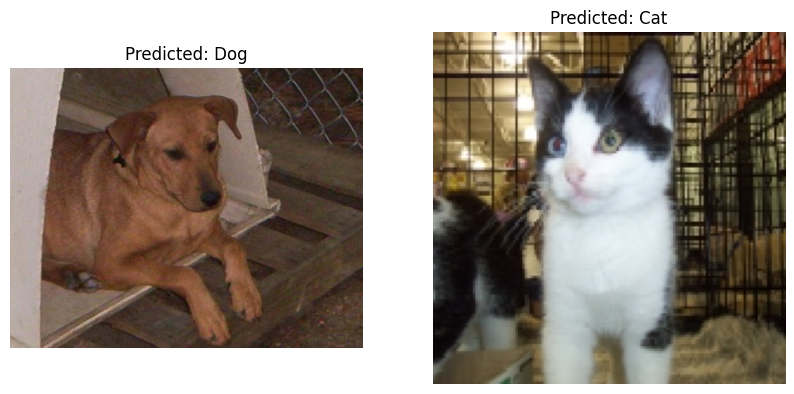

In [ ]:
cat_img = image.load_img(cat_img_path)
dog_img = image.load_img(dog_img_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cat_img)
plt.title(f"Predicted: {predicted_cat_class}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dog_img)
plt.title(f"Predicted: {predicted_dog_class}")
plt.axis('off')

plt.show()